In [1]:
import os
import zipfile
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import glob

# Убедимся, что нужные ресурсы nltk загружены
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Загрузка данных

In [2]:
# Загружаем данные
!wget https://fs22.getcourse.ru/fileservice/file/download/a/607293/sc/162/h/de0e0d48d19479197c8569e5beb086a0.zip -O dataset.zip

--2024-10-13 08:26:40--  https://fs22.getcourse.ru/fileservice/file/download/a/607293/sc/162/h/de0e0d48d19479197c8569e5beb086a0.zip
Resolving fs22.getcourse.ru (fs22.getcourse.ru)... 212.41.15.231
Connecting to fs22.getcourse.ru (fs22.getcourse.ru)|212.41.15.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90020 (88K) [application/x-zip-compressed]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  87.91K   275KB/s    in 0.3s    

2024-10-13 08:26:42 (275 KB/s) - ‘dataset.zip’ saved [90020/90020]



In [3]:
# Распаковываем скачанный ZIP-файл
!unzip dataset.zip -d ./

Archive:  dataset.zip
   creating: ./sampled_texts/
  inflating: ./sampled_texts/02744957d6adcbd9b79897afbf43c15c5e96bd656488240be62b6f0e52c5a57a.txt  
  inflating: ./sampled_texts/028b1196a6d406ef89fb5e7b68c6aeffbf7c16222f59f95515dfae21a69c8136.txt  
  inflating: ./sampled_texts/03d075029311750d531673518196d0702eb863de23f7533a1232df023851b5af.txt  
  inflating: ./sampled_texts/04a95d3a271403ad7cec629227eb8cd101bf28847fcbecb43c0071080ab14d69.txt  
  inflating: ./sampled_texts/06636851bb354d67cb44a1dda898cd924bf412bbe472687c6651012bde4a8d6c.txt  
  inflating: ./sampled_texts/0785bf19f5ced335c289663a6b7606c7f865e761fcd12b19912e630bd45c703e.txt  
  inflating: ./sampled_texts/08fafb97968235a496a5b0ae4f319c40af11f86b75811996591f596bf15954b4.txt  
  inflating: ./sampled_texts/08fccbbee070aa0d7000dfeeac84f0d660c34a624fb34d1f984d345da8f8f84d.txt  
  inflating: ./sampled_texts/092dc838393630ea9439b4e433ebaa273533bb1ac415a52176dfc0ceb8dcf7d8.txt  
  inflating: ./sampled_texts/0971a42ebe6420b2b3a

## 1. Чтение текстовых документов

In [4]:
# Функция для предобработки текста
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Токенизация
    words = word_tokenize(text)
    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [5]:
# Функция для чтения документов
def read_documents(folder_path):
    documents = []
    for file_path in glob.glob(os.path.join(folder_path, '*.txt')):
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()  # Удаляем лишние пробелы в начале и конце документа
            # Разделим текст на блоки по пустой строке (тема и текст разделены пустой строкой)
            parts = content.split('\n\n')
            if len(parts) == 2:
                topic = parts[0].replace('Topic: ', '')
                text = parts[1].replace('Text: ', '')
                # Предобработка текста
                preprocessed_text = preprocess_text(text)
                documents.append({'topic': topic, 'text': preprocessed_text})
            else:
                print(f"Проблема с файлом: {file_path}")  # Если структура документа нарушена
    return documents

In [6]:
# Чтение и предобработка всех документов
documents = read_documents('/content/sampled_texts/')

In [7]:
documents[0]

{'topic': 'Oil prices up on Yukos woes',
 'text': 'new york oil price broke 46 yesterday russian oil giant yukos said would cut oil shipment china first toll export company financial turmoil'}

In [8]:
len(documents)

200

## 2. Преобразование текстов в эмбеддинги

Для преобразования текста в эмбеддинги используем модель из библиотеки sentence-transformers, которая позволяет получить качественные эмбеддинги предложений.

In [9]:
documents[:3]

[{'topic': 'Oil prices up on Yukos woes',
  'text': 'new york oil price broke 46 yesterday russian oil giant yukos said would cut oil shipment china first toll export company financial turmoil'},
 {'topic': 'Brazilian Soldier Wounded in Haiti Unrest',
  'text': 'ltpgtltpgtltpgt joseph guyler delvaltpgtltpgt gonaives haiti reuters brazilian soldier theun peacekeeping force haiti shot wounded saturdaywhen peacekeeper local police faced gunfire crackdownon armed gang haitian capitalltpgt'},
 {'topic': 'Colombian Military Kills Militia Leader',
  'text': 'former ustrained colombian army officer later joined outlawed paramilitary group killed clash army troop tuesday army said'}]

### Установка библиотеки sentence_transformers

In [10]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 5.5 MB/s eta 0:00:00


### Эмбеддинг

In [11]:
from sentence_transformers import SentenceTransformer

# Загрузка модели
model = SentenceTransformer('all-MiniLM-L6-v2')

# Преобразование текстов в эмбеддинги
texts = [doc['text'] for doc in documents]
embeddings = model.encode(texts)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
embeddings[0]

array([-1.42517202e-02, -3.58148776e-02,  1.39985830e-01,  4.33090813e-02,
        1.14532013e-03, -6.10814393e-02, -5.51872775e-02,  2.53805630e-02,
       -4.09715399e-02, -5.57271130e-02, -8.24348032e-02,  4.44516055e-02,
       -1.52872026e-01, -2.42622662e-03, -2.91967969e-02, -4.12575435e-03,
        9.28712636e-03,  9.38758068e-03, -7.25585446e-02, -1.53869092e-02,
        1.76961776e-02, -5.35391569e-02, -8.17811862e-03,  4.69182478e-03,
        4.76723351e-02,  1.67474020e-02, -3.87720787e-03,  1.79767814e-02,
        6.69828206e-02, -2.93925870e-02, -7.71190971e-02,  7.74818996e-04,
       -6.19601496e-02,  3.56181897e-02,  3.37129496e-02,  1.21409558e-02,
        1.11797638e-02, -1.95899121e-02,  6.07329719e-02,  2.35060975e-02,
        4.91666347e-02, -2.13579740e-02, -2.35188119e-02, -1.44440141e-02,
        3.15133035e-02, -9.93587635e-03, -6.42354861e-02,  6.50271848e-02,
        1.06222652e-01,  3.09553295e-02, -6.23848438e-02,  6.01171143e-02,
       -9.71738547e-02,  

In [13]:
import pickle

# Запишем эмбединги в файл data_embeddings.pkl для дальнейшего предсказания класса
with open('data_embeddings.pkl', 'wb') as file:
    pickle.dump(embeddings, file)

## 3. Кластеризация документов

Для кластеризации используем KMeans. Чтобы определить оптимальное количество кластеров, применим метод локтя или силуэтный коэффициент.

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Попробуем разные количества кластеров
distortions = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    distortions.append(kmeans.inertia_)  # Метод локтя
    silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))  # Силуэтный коэффициент

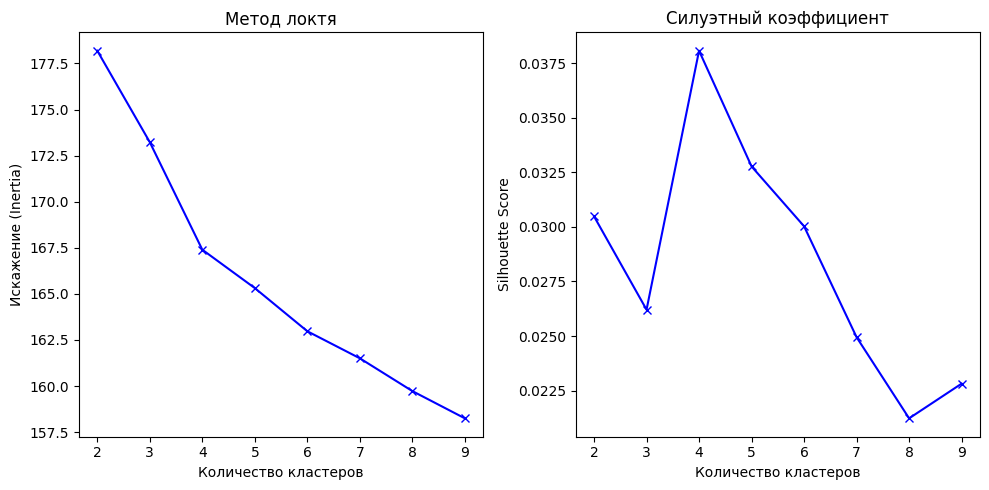

In [15]:
# Построение графиков
plt.figure(figsize=(10, 5))

# График для метода локтя
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Количество кластеров')
plt.ylabel('Искажение (Inertia)')
plt.title('Метод локтя')

# График для силуэтного коэффициента
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Силуэтный коэффициент')

plt.tight_layout()
plt.show()

Видим, что оптимальное количество кластеров - 4

In [16]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(embeddings)

# Добавим метку кластера в документы
for i, doc in enumerate(documents):
    doc['cluster'] = kmeans.labels_[i]

In [17]:
import pickle

# Запишем содержимое documents в файл data_documents.pkl для дальнейшего предсказания класса
with open('data_documents.pkl', 'wb') as file:
    pickle.dump(documents, file)

## 4. Классификация новых документов

In [18]:
# Чтение pickle файлов
with open('data_documents.pkl', 'rb') as file:
    documents = pickle.load(file)

with open('data_embeddings.pkl', 'rb') as file:
    embeddings = pickle.load(file)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Функция классификации нового документа
def classify_new_document(file_path):
    # Проверка существования файла
    if not os.path.exists(file_path):
        return "Файл не найден."

    # Чтение и предобработка нового документа
    with open(file_path, 'r', encoding='utf-8') as f:
        new_text = f.read().strip()

    # Найдем индекс строки "Text: "
    start_index = new_text.find("Text: ")

    # Извлечем текст после "Text: "
    if start_index != -1:
        # Учитываем длину строки "Text: " (5 символов) и пробел после двоеточия
        extracted_text = new_text[start_index + 6:]  # +6 чтобы учесть "Text: " и пробел
    else:
        extracted_text = ""
    preprocessed_new_text = preprocess_text(extracted_text)
    new_embedding = model.encode([preprocessed_new_text])

    # Вычисление косинусного расстояния между новым документом и всеми кластерами
    similarities = cosine_similarity(new_embedding, embeddings)
    most_similar_index = np.argmax(similarities)
    predicted_cluster = documents[most_similar_index]['cluster']

    return f"Новый документ принадлежит кластеру: {predicted_cluster}"

In [21]:
# Пример использования.
# Для теста использовалась папка с документом в Google Drive, т.к. обучение проводильось Google Colab
classify_new_document('/content/drive/MyDrive/Colab Notebooks/lad-academy/texts/1.txt')

'Новый документ принадлежит кластеру: 1'